## Constructing a grid of posterior values

To illustrate an example of how to make a grid of posterior values, we use a nonlinear model from Andy Lawrence which is explained in more detail in his book - a slow flare in the flux (brightness) of a quasar. The idea is, on the assumption of the microlensing theoretical model, to see what values of the parameters of that model look best, using standard Bayesian methodology. In this notebook we just construct the posterior grid. Other notebooks will look at how to get best fit values and confidence ranges from the posterior grid. 

First some standard setup:

In [1]:
from math import *
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


### Read in the data

The data is in the file "fluxes.txt". The data consists of brightness (flux) of the quasar as a function of time, in units of "Modified Julian Days" (MJD), along with the error on the flux. As explained in the notes, we need to include an extra error component for the scatter caused by intrinsic variability, but we have already done that. The error given in the data file is all we need. 

In [2]:
fdata='fluxes.txt'
t=np.loadtxt(fdata,usecols=(1)) # dates from 2nd column, MJD
F=np.loadtxt(fdata,usecols=(2)) # fluxes from 3rd column
Ferr=np.loadtxt(fdata,usecols=(3)) # errors from 4th column
npts=len(t)  # number of datapoints

### The model

The model that we want to fit is the microlensing model: you don't need to understand it in detail. This model involves three nonlinear equations:

$$ y(t) = \sqrt{y_0^2 + (t-t_0)/t_E} $$

$$\mu(y) = \frac{y^2+2} {\sqrt{y(y^2+4)}} $$

$$F(t) = F_0 \mu(t)$$

In these equations, $y(t)$ is the angular distance of the lens from the quasar as it moves with time; $y_0$ is the "impact parameter": the value of $y$ at $t_0$, the time of closest approach; $t_E$ is the Einstein timescale; $\mu(t)$ is the resulting magnification factor; $F_0$ is the baseline flux; and finally $F(t)$ is the observed flux as a function of time. Basically the model has one input: time $t$ and one output: flux $F$ - and we have to determine four parameters $y_0$, $t_0$, $t_E$ and $F_0$ 

### The parameters of the model

The model has four parameters: $F_0, t_0, t_E$ and $y_0$.

From physical principles, and by inspection of the data, astronomers already have an accurate idea of $F_0$ and $t_0$, so we can choose to **fix** those two parameters, and treat the other two, $y_0$ and $t_E$ as the two **interesting** parameters which we want to optimise.  

In [3]:
### set fixed params at reasonable values
### only play with these if you want to see the effect
F0=3.31 # pre-lensed flux
t0=55816. # peak time

### Set up parameter grid

We need to set up arrays of values for our two interesting parameters, with ranges and a number of grid points. The bigger you make $n_{grid}$, the better defined our posterior probability surface will be, but the longer the notebook will take to run! I have set it at a reasonable compromise value of $n_{grid}=30$. 

In [4]:
ngrid=30  # number of grid points in each dimension
tEmin=3000.
tEmax=5000.
y0min=0.06
y0max=0.15
tE=np.linspace(tEmin,tEmax,ngrid) # 1D grid of tE points
y0=np.linspace(y0min,y0max,ngrid) # 1D grid of y0 points
# make 2D co-ordinate grids of matching xy values 
# needed for calculation and plotting later
xtE,yy0=np.meshgrid(tE,y0) 

### Set up the priors

For $t_E$, the Einstein timescale, we choose to make the prior flat between the min and max values set above. For $y_0$, the impact parameter, we go for a prior that is weighted linearly towards larger values, within the min and max range set above. You could try changing these assumed priors to see what difference it makes.

Note that we start by setting 1D priors, then combine them to make the joint probability density. Note that below we calculate the un-normalised version of the posterior, so likewise it doesn't matter whether the priors are normalised. We include a fudge factor so we can make the numbers easier to work with if we want to.

In [20]:
dum=np.ones(ngrid)
prtE=dum/(tEmax-tEmin) # prob per unit tE
pry0=y0/(y0max*y0max - y0min*y0min) # prob per unit y0

pr=np.zeros((ngrid,ngrid))
K=1.0  # arbitrary re-normalisation factor
for j in range(0,ngrid):
    for k in range(0,ngrid):
        pr[j,k]=K*prtE[j]*pry0[k]

#  And alternative prior is to use random numbers - this leaves an imprint on the final result try it and see!       
#pr=np.random.rand(ngrid,ngrid)
#pr = pr/sum(pr)

### Calculate the posterior grid.

We now calculate the un-normalised version of the posterior - just likelihood times prior. The recipe is as follows:

* loop over the grid of parameter values
* at each point in the parameter space, loop over the data points
* each data point has a $t$ and $F_{obs}$ and $F_{err}$ value... 
* the $t$ gives a predicted flux $F_{pred}(t)$ value using the model equations above
* calculate likelihood for that data point given $F_{pred}$, $F_{obs}$ , and $F_{err}$
* go to next data point
* multiply all the likelihoods for the various data points to get joint likelihood
* multiply by the prior to get the (relative) posterior
* go to next pair of parameter values..

The likelihood is the Gaussian probability density given $\mu=F_{pred}$,  $x=F_{obs}$, and $\sigma=F_{err}$ for that data point. Note also that we are assuming that the data points are independent, so that the joint likelihood just involves multiplying the individual likelihoods together. 

In [21]:
# Po is 2D array of posterior values
# Kpo is normalisation factor to keep numbers manageable

Po=np.zeros((ngrid,ngrid))  # initialise posterior
logPo=np.ones((ngrid,ngrid))
KPo=1.e-35                # set fudge factor

# loop over the parameter array
for j in range(0,ngrid):                 
    for k in range(0,ngrid):        
        L=1.0e100
# at each point in parameter space, loop over data points
# accumulate likelihood
# then multiply by prior to get posterior
        for i in range(0,npts):      
            y=(yy0[j,k]*yy0[j,k] + ((t[i]-t0)/xtE[j,k])**2)**0.5
            mu=(y*y+2)/(y*(y*y+4)**0.5)
            Fpred=mu*F0
            dum=stats.norm.pdf(F[i],Fpred,Ferr[i])
            L=L*dum
        Po[j,k]=L*pr[j,k]*KPo
        logPo[j,k]=log10(Po[j,k])


### Plot the posterior array

There are various ways to visualise a 2D array of values. Here we use the Bokeh image routine to get a colour image. 

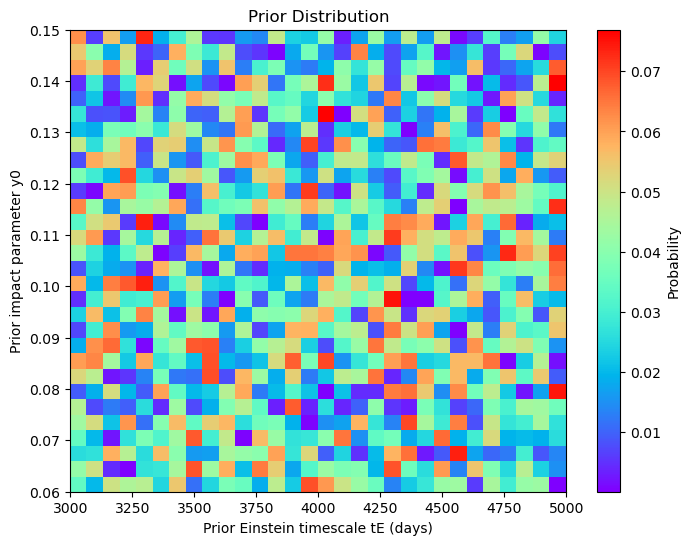

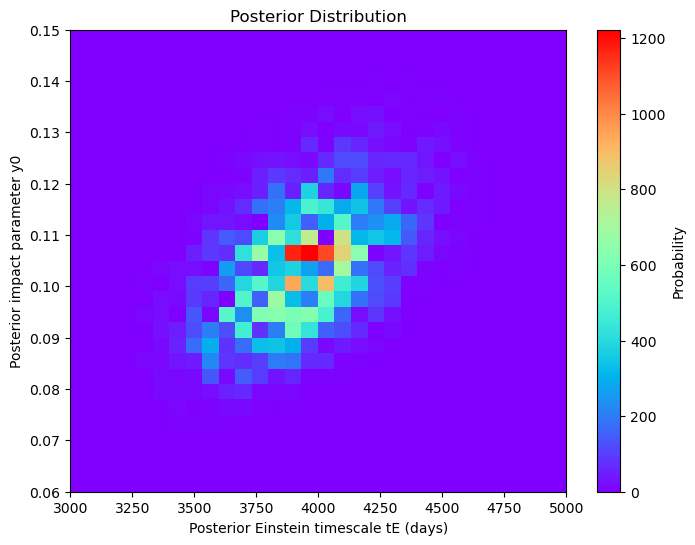

In [22]:


# Create prior Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Prior Distribution")
ax.set_xlabel("Prior Einstein timescale tE (days)")
ax.set_ylabel("Prior impact parameter y0")

# Plotting the image using imshow
im = ax.imshow(pr, extent=[tEmin, tEmax, y0min, y0max], origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(im, ax=ax, label="Probability")
plt.show()
  
# Create posterior Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Posterior Distribution")
ax.set_xlabel("Posterior Einstein timescale tE (days)")
ax.set_ylabel("Posterior impact parameter y0")

# Plotting the image using imshow
im = ax.imshow(Po, extent=[tEmin, tEmax, y0min, y0max], origin='lower', cmap='rainbow', aspect='auto')
plt.colorbar(im, ax=ax, label="Probability")

# Show the Matplotlib plot
plt.show()

### Result and next steps

So we can see visually that our parameters $t_E$ and $y_0$ are highly correlated, and the values that maximise posterior probability are roughly about $t_E\sim 3940$ days and $y_0 \sim 0.103$. We could get a more accurate location by using one of the several grid-search methods described in the notes. However, because we have quite a few data points, the central region should be close to Gaussian, so we can use simplified methods, which we will explore in a separate notebook.

## Analysing posterior grid using Gaussian approximation

Here we analyse the grid of posterior values that we made in the Pgrid notebook. I 
I did a run with $n_{grid}=25$ and saved three arrays: the posterior array Po(i,j), and the matching parameter arrays for the possible values of the Einstein timescale $t_E(i)$, and the impact parameter $y_{imp}(j)$

In this section we will use $I$ for the impact parameter, so it will have a best-fit value of $I_0$, and keep $y$ as a short-hand for $\log P$ .



In [23]:
 
Imin=y0min 
Imax=y0max  
#Read in the arrays
#Po=np.loadtxt('Posave.txt')
#tE=np.loadtxt('tEsave.txt')
#I=np.loadtxt('y0save.txt')
I=(y0)


### Construct the marginal distributions of tE and I Plot the marginal distributions


Plot the marginalised values of $P$
  versus $t_E$
  and  $I$
  respectively to see if the shapes look reasonable.


In [24]:
PmargtE=np.zeros(ngrid)
PmargI=np.zeros(ngrid)

for j in range(0,ngrid):
    ys=Po[j,:]
    PmargtE[j]=np.sum(ys)

for k in range(0,ngrid):
    xs=Po[:,k]
    PmargI[k]=np.sum(xs)

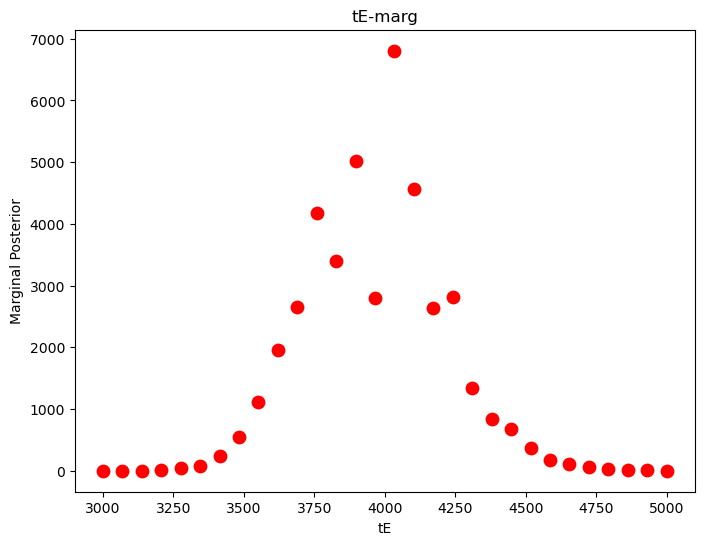

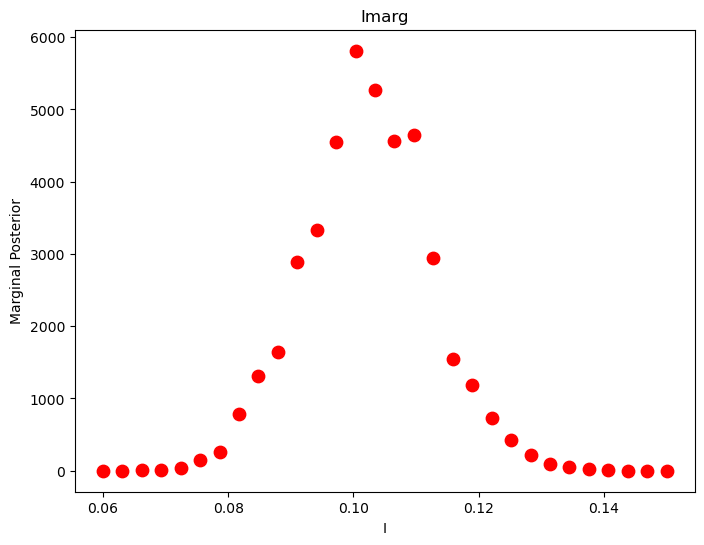

In [25]:

# Plotting tE-marg
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.set_title("tE-marg")
ax1.set_xlabel("tE")
ax1.set_ylabel("Marginal Posterior")

# Plotting the circle points
ax1.scatter(tE, PmargtE, color="red", s=80)

# Show the Matplotlib plot for tE-marg
plt.show()

# Plotting Imarg
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_title("Imarg")
ax2.set_xlabel("I")
ax2.set_ylabel("Marginal Posterior")

# Plotting the circle points
ax2.scatter(I, PmargI, color="red", s=80)

# Show the Matplotlib plot for Imarg
plt.show()


### Locating the peak

For each marginal curve, we first need to locate the maximum value, record the index number of that value, then take a point either side. (We could actually use ANY three points, but the closer we are to the peak, the better the Gaussian approximation will be).

We then take $y=\log P$, and use the parabolic fit formulae from the notes 

$$ \theta_0=\theta_3 - \Delta\theta\left[  
\frac{y_3 - y_2}{y_1 - 2y_2 + y_3} + \frac{1}{2}
\right] 
\qquad{\rm and}\qquad
\sigma_\theta = \Delta\theta \sqrt{\left( 2y_2 - y_1 - y_3 \right)^{-1}}
$$

where $\theta$ is the parameter ($t_E$ and $I$ in turn) and $y=\log P^\prime$

In [26]:
# start with x-axis (PmargtE) 

PtEmax=np.amax(PmargtE) # max value of Pmargx
itEmax=np.argmax(PmargtE) # index where this occurs
y2=log(PmargtE[itEmax]); theta2=tE[itEmax]
y1=log(PmargtE[itEmax-1]); theta1=tE[itEmax-1]
y3=log(PmargtE[itEmax+1]); theta3=tE[itEmax+1]
deltheta=theta3-theta2

dum=(y3-y2)/(y1-2.*y2+y3)
tE0= theta3 - deltheta*(dum + 0.5)
dum=(2.*y2-y1-y3)
sigtE=deltheta*sqrt(1/dum)
print("Gaussian fit: tE0=",round(tE0,1), " sigma-tE=",round(sigtE,1))

Gaussian fit: tE0= 4047.6  sigma-tE= 60.8


### Testing the Gaussian fit

Now let's try plotting a Gaussian with those parameters over the top of the marginal distribution $P(t_E)$ to see if looks right. Of course we have used *relative* P-values throughout, and have not attempted to find the Bayesian normalising factor $E$. So what normalisation should be used? The simplest approach is fix the normalisation so that the Gaussian goes through one of the points. We can also plot the fit on a finer grid.

Start with PmargtE:

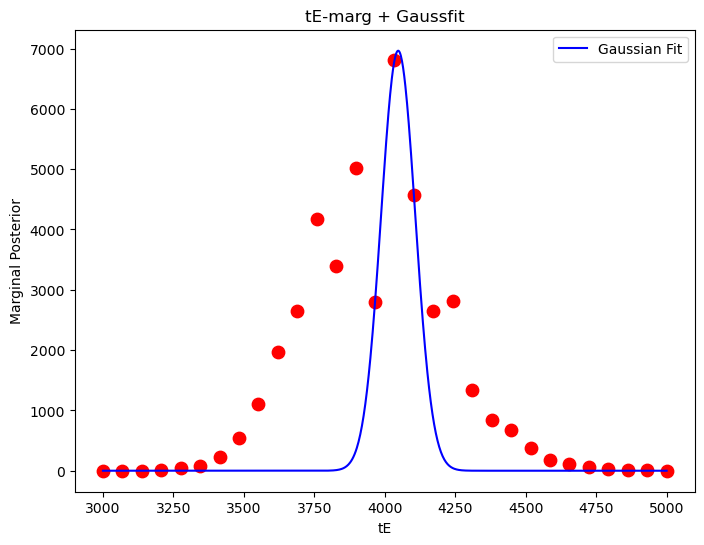

In [27]:
Gtheta1=stats.norm.pdf(theta1,tE0,sigtE)
Gnorm=PmargtE[itEmax-1]/Gtheta1

Ggrid=np.linspace(tEmin,tEmax,1000)
Gfit=np.zeros(len(Ggrid))
for i in range(0,len(Ggrid)):
    Gfit[i]=Gnorm*stats.norm.pdf(Ggrid[i],tE0,sigtE)


# Plotting tE-marg with Gaussian fit
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.set_title("tE-marg + Gaussfit")
ax3.set_xlabel("tE")
ax3.set_ylabel("Marginal Posterior")

# Plotting the circle points
ax3.scatter(tE, PmargtE, color="red", s=80)

# Plotting the Gaussian fit curve
ax3.plot(Ggrid, Gfit, color="blue", label="Gaussian Fit")

# Show the Matplotlib plot for tE-marg with Gaussian fit
plt.legend()
plt.show()

Overall the Gaussian approximation is very good in the core, and starts to break down in the wings. **Now check for PmargI and plot**:

Gaussian fit: I0= 0.101  sigma-I= 0.005


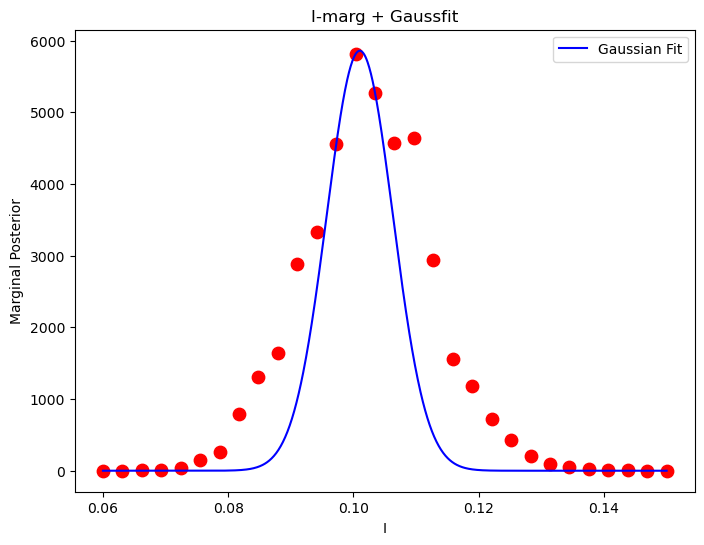

In [28]:
PImax=np.amax(PmargI) # max value of Pmargx
iImax=np.argmax(PmargI) # index where this occurs
y2=log(PmargI[iImax]); theta2=I[iImax]
y1=log(PmargI[iImax-1]); theta1=I[iImax-1]
y3=log(PmargI[iImax+1]); theta3=I[iImax+1]
deltheta=theta3-theta2

dum=(y3-y2)/(y1-2.*y2+y3)
I0= theta3 - deltheta*(dum + 0.5)
dum=(2.*y2-y1-y3)
sigI=deltheta*sqrt(1/dum)
print("Gaussian fit: I0=",round(I0,3), " sigma-I=",round(sigI,3))

Gtheta1=stats.norm.pdf(theta1,I0,sigI)
Gnorm=PmargI[iImax-1]/Gtheta1

Ggrid=np.linspace(Imin,Imax,1000)
Gfit=np.zeros(len(Ggrid))
for i in range(0,len(Ggrid)):
    Gfit[i]=Gnorm*stats.norm.pdf(Ggrid[i],I0,sigI)

# Plotting I-marg with Gaussian fit
fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.set_title("I-marg + Gaussfit")
ax4.set_xlabel("I")
ax4.set_ylabel("Marginal Posterior")

# Plotting the circle points
ax4.scatter(I, PmargI, color="red", s=80)

# Plotting the Gaussian fit curve
ax4.plot(Ggrid, Gfit, color="blue", label="Gaussian Fit")

# Show the Matplotlib plot for I-marg with Gaussian fit
plt.legend()
plt.show()


### Confidence ranges on each parameter.

The Gaussian seems to be a good fit for both parameters, and we have a location for the best fit parameter values at $t_E = 3948.1 $ and $I=0.102$. The width of the Gaussian in each axis is $\sigma(t_E)=229.5$ and $\sigma(I)=0.01$. If the full 2D posterior grid is then a bivariate Gaussian, those will be the appropriate $\sigma$ values for the two components. 

Finally, what is the error range on each parameter? Specifically, suppose we want a 68% range, like the $\pm\sigma$ range in a normal 1D Gaussian. As usual, the right thing to do depends on the exact question you are asking... To simplify, for the moment lets assume the two parameters are uncorrelated, and that the $\sigma$'s are the same in both dirrections. The situation is like in the figure below:

<figure style="text-align: center">
<br>
  <img src="joint.jpg" alt="hmm" width="300">
<br>
</figure>


The contours of equal probability density are circles, and are labelled with $k$ values as in $R=k\sigma$. So $k=1$ corresponds to the 1D $\sigma$ value we get out of the marginalised distribution. We can quote the error on the $y$ parameter as $\pm\sigma$ if we *don't care at all* about the value of the $x$ parameter. This is the yellow region - imagined to stretch to infinity in both directions. It does indeed contain 68% integrated probability, but it's not very good because it includes all sorts of very unlikely values of $x$. It seems better to locate a circular contour that contains 68%. To do this, we need the pink circle at $k=1.52$. The grey circle at $k=1$ is no good - it contains 39.3% of the integrated probability.

One way of looking at this is that we could say

$$y=y_0\pm\sigma, \quad x=x_0 \pm \infty$$

or we could say

$$y=y_0\pm1.52\sigma, \quad x=x_0 \pm 1.52\sigma$$

Overall the lesson is that it doesn't make sense to quote the errors on individual parameters separately, without saying what you are assuming about the other parameter(s). You need to specify some kind of *joint uncertainty*.